In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

**Feature Engeneering**

In [124]:
csv = pd.read_csv('../cleaned_hr_data.csv')
print(csv.columns)
print(csv.dtypes)

#csv = pd.get_dummies(csv, drop_first=True)
print(csv.columns)

selected_features = [
    "OverTime",
    "TotalWorkingYears",
    "JobLevel",
    "YearsInCurrentRole",
    "MonthlyIncome",
    "Age",
    "YearsWithCurrManager",
    "YearsAtCompany",
    "StockOptionLevel",
    "JobInvolvement",
    "JobSatisfaction",
    "WorkLifeBalance",
    "EnvironmentSatisfaction",
    "RelationshipSatisfaction",
    "BusinessTravel",
    "MaritalStatus",
    "Gender",
    'JobRole'
]


def feature_engineering(df):
    df_new = df[selected_features].copy()

    # Employees under 2 years in company
    df_new["EarlyTenure"] = (df_new["YearsAtCompany"] <= 2).astype(int)

    # Overtime as numeric (ensure 0/1 encoding)
    #df_new["OverTime"] = df_new["OverTime"].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

    # Overtime x Tenure Interaction
    df_new["OverTime_Tenure_Interaction"] = (
        df_new["OverTime"] * df_new["YearsAtCompany"]
    )

    # IncomeBand as numeric
    df_new["IncomeBand"] = pd.cut(
        df_new["MonthlyIncome"],
        bins=[0, 2911, 8379, 999999],
        labels=[0, 1, 2],
    ).astype(int)

    # Tenure Stability - ratio of years in current role to total company tenure
    df_new["TenureStability"] = df_new["YearsInCurrentRole"] / (
        df_new["YearsAtCompany"] + 1
    )

    # Composite Satisfaction Score
    df_new["SatisfactionScore"] = (
        df_new["JobSatisfaction"]
        + df_new["EnvironmentSatisfaction"]
        + df_new["RelationshipSatisfaction"]
        + df_new["WorkLifeBalance"]
    )

    # Frequent Travel as binary indicator
    df_new["TravelFrequently"] = (
        df_new["BusinessTravel"] == "Travel_Frequently"
    ).astype(int)

    # One-Hot Encoding for categorical variables with integer dtype
    df_new = pd.get_dummies(
        df_new,
        columns=["BusinessTravel", "MaritalStatus", "Gender", 'JobRole'],
        drop_first=True,
        dtype=int
    )

    return df_new





Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')
Age                          int64
Attrition                    int64
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction   

**Train XGBoost**

In [28]:
!conda install -c conda-forge xgboost -y

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [113]:
import sys
!{sys.executable} -m pip uninstall xgboost -y
!{sys.executable} -m pip install xgboost==1.7.0
!{sys.executable} -m pip install --upgrade optuna
!{sys.executable} -m pip install plotly


Found existing installation: xgboost 1.7.0
Uninstalling xgboost-1.7.0:
  Successfully uninstalled xgboost-1.7.0
  Using cached xgboost-1.7.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)
Reason for being yanked: <none given>
You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.


In [131]:
import sklearn as sk
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import pandas as pd


X = feature_engineering(csv)
y = csv["Attrition"]
print(X.dtypes)

X = feature_engineering(csv)
y = csv["Attrition"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    alpha=0.01,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(model.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))
print("\nClassification Repor baselinet:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

OverTime                            int64
TotalWorkingYears                   int64
JobLevel                            int64
YearsInCurrentRole                  int64
MonthlyIncome                       int64
Age                                 int64
YearsWithCurrManager                int64
YearsAtCompany                      int64
StockOptionLevel                    int64
JobInvolvement                      int64
JobSatisfaction                     int64
WorkLifeBalance                     int64
EnvironmentSatisfaction             int64
RelationshipSatisfaction            int64
EarlyTenure                         int64
OverTime_Tenure_Interaction         int64
IncomeBand                          int64
TenureStability                   float64
SatisfactionScore                   int64
TravelFrequently                    int64
BusinessTravel_no                   int64
BusinessTravel_rarely               int64
MaritalStatus_Married               int64
MaritalStatus_Single              

**OPTUNA HYPERPARAMETER TUNING**

In [126]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10),
        'random_state': 42
    }

    # Train/Validation Split
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    #model
    model = XGBClassifier(**param)

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # prediction
    y_pred = model.predict(X_val)

    # F1-Score for binary classification
    score = f1_score(y_val, y_pred)

    return score

# study
study = optuna.create_study(
    direction='maximize',
    study_name='xgboost_attrition',
    sampler=optuna.samplers.TPESampler(seed=42)
)


study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-11-25 17:37:07,139] A new study created in memory with name: xgboost_attrition
Best trial: 0. Best value: 0:   2%|▏         | 1/50 [00:00<00:16,  3.01it/s]

[I 2025-11-25 17:37:07,481] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 812, 'max_depth': 12, 'learning_rate': 0.1001303991139125, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'colsample_bylevel': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'min_child_weight': 13, 'gamma': 3.540362888980227, 'scale_pos_weight': 0.3037864935284442}. Best is trial 0 with value: 0.0.


Best trial: 1. Best value: 0.56:   4%|▍         | 2/50 [00:01<00:40,  1.18it/s]

[I 2025-11-25 17:37:08,688] Trial 1 finished with value: 0.56 and parameters: {'n_estimators': 1943, 'max_depth': 11, 'learning_rate': 0.011927270244911253, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'colsample_bylevel': 0.7216968971838151, 'reg_alpha': 0.00052821153945323, 'reg_lambda': 7.71800699380605e-05, 'min_child_weight': 6, 'gamma': 3.0592644736118975, 'scale_pos_weight': 1.4809892204552142}. Best is trial 1 with value: 0.56.


Best trial: 1. Best value: 0.56:   6%|▌         | 3/50 [00:01<00:31,  1.50it/s]

[I 2025-11-25 17:37:09,145] Trial 2 finished with value: 0.5151515151515151 and parameters: {'n_estimators': 655, 'max_depth': 6, 'learning_rate': 0.03235425596639437, 'subsample': 0.9140703845572055, 'colsample_bytree': 0.6798695128633439, 'colsample_bylevel': 0.8056937753654446, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08, 'min_child_weight': 13, 'gamma': 0.8526206184364576, 'scale_pos_weight': 0.7440107705542672}. Best is trial 1 with value: 0.56.


Best trial: 3. Best value: 0.613636:   8%|▊         | 4/50 [00:03<00:48,  1.05s/it]

[I 2025-11-25 17:37:10,777] Trial 3 finished with value: 0.6136363636363636 and parameters: {'n_estimators': 1903, 'max_depth': 12, 'learning_rate': 0.1369060876012629, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'colsample_bylevel': 0.8736932106048627, 'reg_alpha': 9.148975058772307e-05, 'reg_lambda': 1.254134495897175e-07, 'min_child_weight': 10, 'gamma': 0.17194260557609198, 'scale_pos_weight': 9.102271980579943}. Best is trial 3 with value: 0.6136363636363636.


Best trial: 3. Best value: 0.613636:  10%|█         | 5/50 [00:04<00:37,  1.21it/s]

[I 2025-11-25 17:37:11,219] Trial 4 finished with value: 0.6050420168067226 and parameters: {'n_estimators': 591, 'max_depth': 9, 'learning_rate': 0.017915933593754683, 'subsample': 0.8080272084711243, 'colsample_bytree': 0.8186841117373118, 'colsample_bylevel': 0.6739417822102108, 'reg_alpha': 5.324289357128436, 'reg_lambda': 0.09466630153726856, 'min_child_weight': 19, 'gamma': 4.474136752138244, 'scale_pos_weight': 6.019209790229743}. Best is trial 3 with value: 0.6136363636363636.


Best trial: 3. Best value: 0.613636:  12%|█▏        | 6/50 [00:05<00:44,  1.01s/it]

[I 2025-11-25 17:37:12,584] Trial 5 finished with value: 0.5918367346938775 and parameters: {'n_estimators': 1852, 'max_depth': 3, 'learning_rate': 0.011154681546966926, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'colsample_bylevel': 0.7554709158757928, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854, 'min_child_weight': 8, 'gamma': 1.4046725484369038, 'scale_pos_weight': 5.47269122326666}. Best is trial 3 with value: 0.6136363636363636.


Best trial: 3. Best value: 0.613636:  14%|█▍        | 7/50 [00:05<00:36,  1.17it/s]

[I 2025-11-25 17:37:13,110] Trial 6 finished with value: 0.5901639344262295 and parameters: {'n_estimators': 367, 'max_depth': 11, 'learning_rate': 0.006784726174512315, 'subsample': 0.9947547746402069, 'colsample_bytree': 0.908897907718663, 'colsample_bylevel': 0.679486272613669, 'reg_alpha': 1.1212412169964432e-08, 'reg_lambda': 0.2183498289760726, 'min_child_weight': 15, 'gamma': 3.6450358402049368, 'scale_pos_weight': 7.735576432190863}. Best is trial 3 with value: 0.6136363636363636.


Best trial: 3. Best value: 0.613636:  16%|█▌        | 8/50 [00:06<00:28,  1.48it/s]

[I 2025-11-25 17:37:13,408] Trial 7 finished with value: 0.6078431372549019 and parameters: {'n_estimators': 240, 'max_depth': 6, 'learning_rate': 0.008035311499213382, 'subsample': 0.9452413703502374, 'colsample_bytree': 0.8493192507310232, 'colsample_bylevel': 0.7323592099410596, 'reg_alpha': 3.732717755563729e-08, 'reg_lambda': 6.292756043818863e-06, 'min_child_weight': 7, 'gamma': 3.64803089169032, 'scale_pos_weight': 6.41181896641661}. Best is trial 3 with value: 0.6136363636363636.


Best trial: 3. Best value: 0.613636:  18%|█▊        | 9/50 [00:07<00:30,  1.35it/s]

[I 2025-11-25 17:37:14,297] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 1786, 'max_depth': 7, 'learning_rate': 0.008158807046157799, 'subsample': 0.885297914889198, 'colsample_bytree': 0.9043140194467589, 'colsample_bylevel': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472, 'min_child_weight': 11, 'gamma': 2.137705091792748, 'scale_pos_weight': 0.35164935476654235}. Best is trial 3 with value: 0.6136363636363636.


Best trial: 3. Best value: 0.613636:  20%|██        | 10/50 [00:07<00:23,  1.71it/s]

[I 2025-11-25 17:37:14,528] Trial 9 finished with value: 0.5294117647058824 and parameters: {'n_estimators': 305, 'max_depth': 3, 'learning_rate': 0.0677023857369087, 'subsample': 0.7257423924305306, 'colsample_bytree': 0.8034282764658811, 'colsample_bylevel': 0.9630265895704372, 'reg_alpha': 1.7523871598466864e-06, 'reg_lambda': 4.9368087974032924e-05, 'min_child_weight': 16, 'gamma': 1.1439908274581123, 'scale_pos_weight': 0.8621011073050506}. Best is trial 3 with value: 0.6136363636363636.


Best trial: 10. Best value: 0.634146:  22%|██▏       | 11/50 [00:08<00:27,  1.44it/s]

[I 2025-11-25 17:37:15,470] Trial 10 finished with value: 0.6341463414634145 and parameters: {'n_estimators': 1349, 'max_depth': 9, 'learning_rate': 0.2648217372114754, 'subsample': 0.7387403565626488, 'colsample_bytree': 0.6058694368028292, 'colsample_bylevel': 0.9151370382614828, 'reg_alpha': 1.7856978181230155e-05, 'reg_lambda': 1.2602282632033272e-08, 'min_child_weight': 2, 'gamma': 0.06155584782468759, 'scale_pos_weight': 9.924057856421186}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  24%|██▍       | 12/50 [00:08<00:26,  1.45it/s]

[I 2025-11-25 17:37:16,147] Trial 11 finished with value: 0.6265060240963854 and parameters: {'n_estimators': 1383, 'max_depth': 9, 'learning_rate': 0.2889967388538741, 'subsample': 0.7370063974951027, 'colsample_bytree': 0.6044023461243514, 'colsample_bylevel': 0.9118473736478345, 'reg_alpha': 1.3755335693766922e-05, 'reg_lambda': 1.1796868791821461e-08, 'min_child_weight': 1, 'gamma': 0.3029223712250912, 'scale_pos_weight': 9.987649028165812}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  26%|██▌       | 13/50 [00:09<00:28,  1.32it/s]

[I 2025-11-25 17:37:17,067] Trial 12 finished with value: 0.5499999999999999 and parameters: {'n_estimators': 1315, 'max_depth': 9, 'learning_rate': 0.28967972986127816, 'subsample': 0.7651456263915392, 'colsample_bytree': 0.6012684102065425, 'colsample_bylevel': 0.9655462118215983, 'reg_alpha': 1.1844206827124668e-05, 'reg_lambda': 4.893214777472011e-07, 'min_child_weight': 1, 'gamma': 0.022630239093436755, 'scale_pos_weight': 9.570773166913739}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  28%|██▊       | 14/50 [00:10<00:25,  1.40it/s]

[I 2025-11-25 17:37:17,681] Trial 13 finished with value: 0.6 and parameters: {'n_estimators': 1344, 'max_depth': 9, 'learning_rate': 0.2986938937472341, 'subsample': 0.6630080698408224, 'colsample_bytree': 0.9861351784261821, 'colsample_bylevel': 0.8993951700461889, 'reg_alpha': 0.00809930329573641, 'reg_lambda': 1.8047122532525672e-08, 'min_child_weight': 1, 'gamma': 2.0760330818165, 'scale_pos_weight': 3.3911692109736356}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  30%|███       | 15/50 [00:11<00:25,  1.37it/s]

[I 2025-11-25 17:37:18,443] Trial 14 finished with value: 0.5499999999999999 and parameters: {'n_estimators': 1440, 'max_depth': 8, 'learning_rate': 0.16122566619283374, 'subsample': 0.7639296286177562, 'colsample_bytree': 0.7495910822966338, 'colsample_bylevel': 0.9041925528530073, 'reg_alpha': 3.7282533628234855e-05, 'reg_lambda': 1.2112347439788523e-06, 'min_child_weight': 3, 'gamma': 0.5986426958159813, 'scale_pos_weight': 8.10690916076523}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  32%|███▏      | 16/50 [00:12<00:25,  1.33it/s]

[I 2025-11-25 17:37:19,251] Trial 15 finished with value: 0.5909090909090908 and parameters: {'n_estimators': 1062, 'max_depth': 10, 'learning_rate': 0.04773317544936739, 'subsample': 0.7020228276855585, 'colsample_bytree': 0.6046738833533556, 'colsample_bylevel': 0.9955405457289747, 'reg_alpha': 6.738672532809276e-07, 'reg_lambda': 0.004603135854043442, 'min_child_weight': 4, 'gamma': 1.46495613832301, 'scale_pos_weight': 9.772745221861179}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  34%|███▍      | 17/50 [00:12<00:25,  1.31it/s]

[I 2025-11-25 17:37:20,035] Trial 16 finished with value: 0.5609756097560976 and parameters: {'n_estimators': 1579, 'max_depth': 7, 'learning_rate': 0.1957582932921978, 'subsample': 0.8509679306459871, 'colsample_bytree': 0.7325047411175833, 'colsample_bylevel': 0.8552794318329083, 'reg_alpha': 2.606506177891247e-07, 'reg_lambda': 5.734921132452755e-06, 'min_child_weight': 4, 'gamma': 0.4109974241266662, 'scale_pos_weight': 7.326142550125618}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  36%|███▌      | 18/50 [00:13<00:23,  1.39it/s]

[I 2025-11-25 17:37:20,654] Trial 17 finished with value: 0.5609756097560976 and parameters: {'n_estimators': 1053, 'max_depth': 5, 'learning_rate': 0.10270870399774265, 'subsample': 0.6212362456865659, 'colsample_bytree': 0.7093607961740002, 'colsample_bylevel': 0.6049023671174069, 'reg_alpha': 0.013132032638840649, 'reg_lambda': 8.346314881031567, 'min_child_weight': 3, 'gamma': 1.7216511371401435, 'scale_pos_weight': 3.1638675619932544}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  38%|███▊      | 19/50 [00:14<00:22,  1.40it/s]

[I 2025-11-25 17:37:21,359] Trial 18 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 1190, 'max_depth': 10, 'learning_rate': 0.030811875550688518, 'subsample': 0.7823296736535549, 'colsample_bytree': 0.632383167447272, 'colsample_bylevel': 0.9296181214321809, 'reg_alpha': 0.0002672929886612469, 'reg_lambda': 1.2759008798270784e-07, 'min_child_weight': 1, 'gamma': 2.7046086604585287, 'scale_pos_weight': 8.82150979876259}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  40%|████      | 20/50 [00:14<00:22,  1.36it/s]

[I 2025-11-25 17:37:22,141] Trial 19 finished with value: 0.5238095238095238 and parameters: {'n_estimators': 1573, 'max_depth': 8, 'learning_rate': 0.19924511520811636, 'subsample': 0.8154233684536227, 'colsample_bytree': 0.7719898235665422, 'colsample_bylevel': 0.8379914982648196, 'reg_alpha': 1.2027826501713481e-05, 'reg_lambda': 1.4329321655479917e-08, 'min_child_weight': 6, 'gamma': 0.815556730567848, 'scale_pos_weight': 4.759246131940519}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  42%|████▏     | 21/50 [00:15<00:19,  1.52it/s]

[I 2025-11-25 17:37:22,620] Trial 20 finished with value: 0.6168224299065419 and parameters: {'n_estimators': 847, 'max_depth': 10, 'learning_rate': 0.06982540373426208, 'subsample': 0.7486721528730329, 'colsample_bytree': 0.696283104444102, 'colsample_bylevel': 0.9327505750541305, 'reg_alpha': 0.20929416374790938, 'reg_lambda': 0.0032144773546522445, 'min_child_weight': 9, 'gamma': 4.522457264033607, 'scale_pos_weight': 9.993005423129347}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  44%|████▍     | 22/50 [00:15<00:16,  1.66it/s]

[I 2025-11-25 17:37:23,090] Trial 21 finished with value: 0.6126126126126126 and parameters: {'n_estimators': 880, 'max_depth': 10, 'learning_rate': 0.06939781879482107, 'subsample': 0.7384866093795285, 'colsample_bytree': 0.6974040046404777, 'colsample_bylevel': 0.9352660703281378, 'reg_alpha': 0.7977059216418064, 'reg_lambda': 0.005464438339010772, 'min_child_weight': 10, 'gamma': 4.943941354058749, 'scale_pos_weight': 9.877104195491844}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  46%|████▌     | 23/50 [00:16<00:16,  1.68it/s]

[I 2025-11-25 17:37:23,671] Trial 22 finished with value: 0.5510204081632653 and parameters: {'n_estimators': 1211, 'max_depth': 9, 'learning_rate': 0.22239629139702372, 'subsample': 0.6779221897091259, 'colsample_bytree': 0.6417664967119547, 'colsample_bylevel': 0.9031635748435352, 'reg_alpha': 0.15776317831930073, 'reg_lambda': 0.0035979516609240493, 'min_child_weight': 5, 'gamma': 4.227656807758924, 'scale_pos_weight': 9.038430741360187}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  48%|████▊     | 24/50 [00:17<00:16,  1.53it/s]

[I 2025-11-25 17:37:24,456] Trial 23 finished with value: 0.5217391304347825 and parameters: {'n_estimators': 1652, 'max_depth': 11, 'learning_rate': 0.11254844314468163, 'subsample': 0.7498987298312838, 'colsample_bytree': 0.6029730544278419, 'colsample_bylevel': 0.984973173365251, 'reg_alpha': 0.0010414990164539367, 'reg_lambda': 0.0007571088163674793, 'min_child_weight': 8, 'gamma': 2.8529985325150196, 'scale_pos_weight': 8.340420845078405}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  50%|█████     | 25/50 [00:18<00:16,  1.47it/s]

[I 2025-11-25 17:37:25,198] Trial 24 finished with value: 0.5742574257425743 and parameters: {'n_estimators': 853, 'max_depth': 8, 'learning_rate': 0.07139316022510135, 'subsample': 0.7866075423407666, 'colsample_bytree': 0.6488074872026166, 'colsample_bylevel': 0.9440553897854047, 'reg_alpha': 8.182325838910824, 'reg_lambda': 0.028428184265606348, 'min_child_weight': 20, 'gamma': 0.027527663538906677, 'scale_pos_weight': 7.021015283028701}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  52%|█████▏    | 26/50 [00:18<00:17,  1.38it/s]

[I 2025-11-25 17:37:26,023] Trial 25 finished with value: 0.5813953488372093 and parameters: {'n_estimators': 1443, 'max_depth': 10, 'learning_rate': 0.046364977443762945, 'subsample': 0.712789170362102, 'colsample_bytree': 0.6981486701329588, 'colsample_bylevel': 0.8783474370669173, 'reg_alpha': 6.340729606090401e-05, 'reg_lambda': 7.110579871732803e-06, 'min_child_weight': 3, 'gamma': 2.2926537816587165, 'scale_pos_weight': 9.964806981948726}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  54%|█████▍    | 27/50 [00:19<00:14,  1.58it/s]

[I 2025-11-25 17:37:26,447] Trial 26 finished with value: 0.5679012345679012 and parameters: {'n_estimators': 555, 'max_depth': 9, 'learning_rate': 0.1454715954903346, 'subsample': 0.6414910906181719, 'colsample_bytree': 0.6256873207952275, 'colsample_bylevel': 0.9288894860930627, 'reg_alpha': 8.776959374285735e-06, 'reg_lambda': 2.969532751595879e-07, 'min_child_weight': 2, 'gamma': 0.4682637966203319, 'scale_pos_weight': 8.501085370362205}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  56%|█████▌    | 28/50 [00:19<00:14,  1.54it/s]

[I 2025-11-25 17:37:27,129] Trial 27 finished with value: 0.5806451612903225 and parameters: {'n_estimators': 1152, 'max_depth': 11, 'learning_rate': 0.22583345401563357, 'subsample': 0.6808186017966071, 'colsample_bytree': 0.7633520702936788, 'colsample_bylevel': 0.7884012556900623, 'reg_alpha': 2.0696875306666643e-07, 'reg_lambda': 5.1533448172151025e-05, 'min_child_weight': 8, 'gamma': 1.0694017441936476, 'scale_pos_weight': 9.089999940789731}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  58%|█████▊    | 29/50 [00:20<00:13,  1.59it/s]

[I 2025-11-25 17:37:27,714] Trial 28 finished with value: 0.6304347826086957 and parameters: {'n_estimators': 714, 'max_depth': 7, 'learning_rate': 0.019820093530600123, 'subsample': 0.8282476714512399, 'colsample_bytree': 0.6749186213473011, 'colsample_bylevel': 0.8660545219764928, 'reg_alpha': 0.004802431255160524, 'reg_lambda': 7.101961222005121e-08, 'min_child_weight': 5, 'gamma': 3.283379528481139, 'scale_pos_weight': 7.575813301892923}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  60%|██████    | 30/50 [00:21<00:12,  1.67it/s]

[I 2025-11-25 17:37:28,247] Trial 29 finished with value: 0.5744680851063829 and parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.02070022303966898, 'subsample': 0.8631857356144131, 'colsample_bytree': 0.6558101753063198, 'colsample_bylevel': 0.8648532508711684, 'reg_alpha': 0.0045589537066694575, 'reg_lambda': 6.593895655143868e-08, 'min_child_weight': 5, 'gamma': 3.0646985188122233, 'scale_pos_weight': 6.689680138382698}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  62%|██████▏   | 31/50 [00:21<00:10,  1.82it/s]

[I 2025-11-25 17:37:28,683] Trial 30 finished with value: 0.6304347826086957 and parameters: {'n_estimators': 483, 'max_depth': 7, 'learning_rate': 0.023270750095150426, 'subsample': 0.8172954543969839, 'colsample_bytree': 0.6722558133053541, 'colsample_bylevel': 0.8336016709979852, 'reg_alpha': 0.0001307690084718359, 'reg_lambda': 1.7326959504878186e-06, 'min_child_weight': 2, 'gamma': 3.3215487634881944, 'scale_pos_weight': 7.667209604703126}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  64%|██████▍   | 32/50 [00:22<00:09,  1.88it/s]

[I 2025-11-25 17:37:29,173] Trial 31 finished with value: 0.6236559139784946 and parameters: {'n_estimators': 437, 'max_depth': 7, 'learning_rate': 0.0203899925802786, 'subsample': 0.8233139596326488, 'colsample_bytree': 0.6774145379427525, 'colsample_bylevel': 0.8367539534263602, 'reg_alpha': 0.00026742759191535146, 'reg_lambda': 9.739459460670807e-07, 'min_child_weight': 2, 'gamma': 3.3616626887234515, 'scale_pos_weight': 7.793693013123278}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 10. Best value: 0.634146:  66%|██████▌   | 33/50 [00:22<00:09,  1.72it/s]

[I 2025-11-25 17:37:29,864] Trial 32 finished with value: 0.6236559139784946 and parameters: {'n_estimators': 973, 'max_depth': 6, 'learning_rate': 0.01407610096288658, 'subsample': 0.8411575861487158, 'colsample_bytree': 0.6256843146602966, 'colsample_bylevel': 0.7696864273775755, 'reg_alpha': 0.026991778931915164, 'reg_lambda': 1.0211130106029364e-08, 'min_child_weight': 2, 'gamma': 3.843288751688683, 'scale_pos_weight': 4.611346181670441}. Best is trial 10 with value: 0.6341463414634145.


Best trial: 33. Best value: 0.652632:  70%|███████   | 35/50 [00:23<00:06,  2.34it/s]

[I 2025-11-25 17:37:30,262] Trial 33 finished with value: 0.6526315789473685 and parameters: {'n_estimators': 481, 'max_depth': 8, 'learning_rate': 0.028034985535646494, 'subsample': 0.8811332677413009, 'colsample_bytree': 0.6678675818127024, 'colsample_bylevel': 0.7984613698928873, 'reg_alpha': 0.00016968431340546033, 'reg_lambda': 4.370748268708481e-08, 'min_child_weight': 5, 'gamma': 3.2717521181181346, 'scale_pos_weight': 7.430193444282004}. Best is trial 33 with value: 0.6526315789473685.
[I 2025-11-25 17:37:30,458] Trial 34 finished with value: 0.625 and parameters: {'n_estimators': 174, 'max_depth': 5, 'learning_rate': 0.03189268639185472, 'subsample': 0.8835007620939239, 'colsample_bytree': 0.6630999450131799, 'colsample_bylevel': 0.8060377179641125, 'reg_alpha': 0.0007228475145113918, 'reg_lambda': 7.323215556595055e-08, 'min_child_weight': 6, 'gamma': 3.0455915811202443, 'scale_pos_weight': 5.771409908901413}. Best is trial 33 with value: 0.6526315789473685.


Best trial: 35. Best value: 0.659574:  72%|███████▏  | 36/50 [00:23<00:05,  2.39it/s]

[I 2025-11-25 17:37:30,855] Trial 35 finished with value: 0.6595744680851063 and parameters: {'n_estimators': 466, 'max_depth': 6, 'learning_rate': 0.02324665104893117, 'subsample': 0.9231152995832982, 'colsample_bytree': 0.6746259650417806, 'colsample_bylevel': 0.8120924106244884, 'reg_alpha': 0.0018042574383877329, 'reg_lambda': 1.7324613406492883e-06, 'min_child_weight': 5, 'gamma': 3.3828995678961222, 'scale_pos_weight': 7.306658449121216}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 35. Best value: 0.659574:  76%|███████▌  | 38/50 [00:24<00:04,  2.71it/s]

[I 2025-11-25 17:37:31,462] Trial 36 finished with value: 0.6168224299065419 and parameters: {'n_estimators': 729, 'max_depth': 6, 'learning_rate': 0.013892623643988224, 'subsample': 0.9321966530035648, 'colsample_bytree': 0.7195536432793981, 'colsample_bylevel': 0.7857931275085888, 'reg_alpha': 0.0039679522643672315, 'reg_lambda': 5.171209882409332e-08, 'min_child_weight': 12, 'gamma': 3.976804337462817, 'scale_pos_weight': 7.044149887565924}. Best is trial 35 with value: 0.6595744680851063.
[I 2025-11-25 17:37:31,586] Trial 37 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 118, 'max_depth': 4, 'learning_rate': 0.027277333958224372, 'subsample': 0.9752354417353811, 'colsample_bytree': 0.6784369986329607, 'colsample_bylevel': 0.7413315119267838, 'reg_alpha': 0.0012726402012296022, 'reg_lambda': 2.7926816095161296e-07, 'min_child_weight': 5, 'gamma': 2.4458112708525306, 'scale_pos_weight': 3.887348040123559}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 35. Best value: 0.659574:  78%|███████▊  | 39/50 [00:24<00:04,  2.67it/s]

[I 2025-11-25 17:37:31,974] Trial 38 finished with value: 0.6304347826086957 and parameters: {'n_estimators': 592, 'max_depth': 8, 'learning_rate': 0.04348516955966031, 'subsample': 0.9043580497205975, 'colsample_bytree': 0.7436242970289302, 'colsample_bylevel': 0.7070744012013985, 'reg_alpha': 0.04375054865746592, 'reg_lambda': 4.069846641658916e-08, 'min_child_weight': 7, 'gamma': 3.2976851694369858, 'scale_pos_weight': 5.355909956887686}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 35. Best value: 0.659574:  80%|████████  | 40/50 [00:25<00:03,  2.62it/s]

[I 2025-11-25 17:37:32,371] Trial 39 finished with value: 0.6067415730337078 and parameters: {'n_estimators': 355, 'max_depth': 7, 'learning_rate': 0.016887179575388923, 'subsample': 0.9598170432394688, 'colsample_bytree': 0.8658446307981037, 'colsample_bylevel': 0.8823717635792164, 'reg_alpha': 0.00044216326346441443, 'reg_lambda': 1.4433847165008778e-05, 'min_child_weight': 4, 'gamma': 2.698631862277302, 'scale_pos_weight': 6.27880117170192}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 35. Best value: 0.659574:  82%|████████▏ | 41/50 [00:25<00:03,  2.39it/s]

[I 2025-11-25 17:37:32,878] Trial 40 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 487, 'max_depth': 8, 'learning_rate': 0.00989788776190468, 'subsample': 0.911661614119037, 'colsample_bytree': 0.7933868652073067, 'colsample_bylevel': 0.8130702482703249, 'reg_alpha': 0.0027518053025611115, 'reg_lambda': 1.7502851502562022e-07, 'min_child_weight': 6, 'gamma': 3.542315560936104, 'scale_pos_weight': 1.9771738535335128}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 35. Best value: 0.659574:  84%|████████▍ | 42/50 [00:26<00:03,  2.41it/s]

[I 2025-11-25 17:37:33,280] Trial 41 finished with value: 0.5957446808510639 and parameters: {'n_estimators': 465, 'max_depth': 7, 'learning_rate': 0.025215078532378657, 'subsample': 0.8685298991695872, 'colsample_bytree': 0.6650436616903161, 'colsample_bylevel': 0.8339630228552778, 'reg_alpha': 8.037377363825973e-05, 'reg_lambda': 1.858081178340445e-06, 'min_child_weight': 3, 'gamma': 3.2645942656424176, 'scale_pos_weight': 7.57656197184915}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 35. Best value: 0.659574:  86%|████████▌ | 43/50 [00:26<00:02,  2.74it/s]

[I 2025-11-25 17:37:33,530] Trial 42 finished with value: 0.6170212765957447 and parameters: {'n_estimators': 281, 'max_depth': 6, 'learning_rate': 0.037274085422398476, 'subsample': 0.8236611915350507, 'colsample_bytree': 0.6828027484248022, 'colsample_bylevel': 0.852703236890353, 'reg_alpha': 0.00021804937112936582, 'reg_lambda': 2.5591737213196083e-06, 'min_child_weight': 4, 'gamma': 3.8815191919754444, 'scale_pos_weight': 6.748491621503103}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 35. Best value: 0.659574:  88%|████████▊ | 44/50 [00:26<00:02,  2.32it/s]

[I 2025-11-25 17:37:34,118] Trial 43 finished with value: 0.6262626262626262 and parameters: {'n_estimators': 728, 'max_depth': 7, 'learning_rate': 0.025457148147843046, 'subsample': 0.8015388757889147, 'colsample_bytree': 0.6334789044010478, 'colsample_bylevel': 0.7665069165365519, 'reg_alpha': 3.255278930272137e-05, 'reg_lambda': 4.390555974692881e-07, 'min_child_weight': 7, 'gamma': 3.0366211404164427, 'scale_pos_weight': 8.044056102262818}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 35. Best value: 0.659574:  90%|█████████ | 45/50 [00:27<00:02,  2.18it/s]

[I 2025-11-25 17:37:34,642] Trial 44 finished with value: 0.5818181818181818 and parameters: {'n_estimators': 587, 'max_depth': 6, 'learning_rate': 0.01965557275770556, 'subsample': 0.8893859283635647, 'colsample_bytree': 0.7185617463099457, 'colsample_bylevel': 0.7928187242323983, 'reg_alpha': 0.00010122681828088318, 'reg_lambda': 3.959617561347956e-08, 'min_child_weight': 14, 'gamma': 3.4400772123322265, 'scale_pos_weight': 8.512066994249006}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 35. Best value: 0.659574:  92%|█████████▏| 46/50 [00:27<00:01,  2.53it/s]

[I 2025-11-25 17:37:34,885] Trial 45 finished with value: 0.5934065934065934 and parameters: {'n_estimators': 379, 'max_depth': 8, 'learning_rate': 0.05539381210664225, 'subsample': 0.9420650441021001, 'colsample_bytree': 0.6574210900955274, 'colsample_bylevel': 0.8195180421314163, 'reg_alpha': 4.879865293689079e-06, 'reg_lambda': 1.7291082345011904e-05, 'min_child_weight': 2, 'gamma': 4.229602590612725, 'scale_pos_weight': 5.994297361391758}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 35. Best value: 0.659574:  94%|█████████▍| 47/50 [00:28<00:01,  2.16it/s]

[I 2025-11-25 17:37:35,507] Trial 46 finished with value: 0.6105263157894737 and parameters: {'n_estimators': 649, 'max_depth': 6, 'learning_rate': 0.01549846656766943, 'subsample': 0.83435947950377, 'colsample_bytree': 0.9982907068888208, 'colsample_bylevel': 0.8848654755092253, 'reg_alpha': 2.5696508949167806e-05, 'reg_lambda': 6.730907188750033e-07, 'min_child_weight': 5, 'gamma': 2.7941380973243684, 'scale_pos_weight': 7.540903769970117}. Best is trial 35 with value: 0.6595744680851063.


Best trial: 47. Best value: 0.659794:  96%|█████████▌| 48/50 [00:29<00:01,  1.86it/s]

[I 2025-11-25 17:37:36,219] Trial 47 finished with value: 0.6597938144329897 and parameters: {'n_estimators': 520, 'max_depth': 7, 'learning_rate': 0.00562992912248873, 'subsample': 0.7862779372792024, 'colsample_bytree': 0.6227217392310765, 'colsample_bylevel': 0.8505095828968313, 'reg_alpha': 1.7018623284170484e-06, 'reg_lambda': 0.00011919871088790451, 'min_child_weight': 3, 'gamma': 3.7021010019141185, 'scale_pos_weight': 9.358082988232631}. Best is trial 47 with value: 0.6597938144329897.


Best trial: 47. Best value: 0.659794:  98%|█████████▊| 49/50 [00:30<00:00,  1.46it/s]

[I 2025-11-25 17:37:37,254] Trial 48 finished with value: 0.6280991735537189 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.005999888094268283, 'subsample': 0.7777096886120152, 'colsample_bytree': 0.6179330937300535, 'colsample_bylevel': 0.8533949563276498, 'reg_alpha': 3.080979067037932e-06, 'reg_lambda': 0.00014513364280447413, 'min_child_weight': 16, 'gamma': 3.669859376045814, 'scale_pos_weight': 9.484894712237807}. Best is trial 47 with value: 0.6597938144329897.


Best trial: 47. Best value: 0.659794: 100%|██████████| 50/50 [00:30<00:00,  1.64it/s]

[I 2025-11-25 17:37:37,589] Trial 49 finished with value: 0.6260869565217391 and parameters: {'n_estimators': 197, 'max_depth': 8, 'learning_rate': 0.010747130928660177, 'subsample': 0.9254864689728809, 'colsample_bytree': 0.6449979686521202, 'colsample_bylevel': 0.7648566632775589, 'reg_alpha': 5.282842932315888e-07, 'reg_lambda': 0.00048237379837196557, 'min_child_weight': 7, 'gamma': 1.7864218585598435, 'scale_pos_weight': 9.312010259503465}. Best is trial 47 with value: 0.6597938144329897.


**VISUALIZE**

In [127]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate
import matplotlib.pyplot as plt



# 1. Optimierungsverlauf
print("Optimization History...")
fig1 = plot_optimization_history(study)
fig1.show()

# 2. Parameter Importance
print("Important Parameter...")
fig2 = plot_param_importances(study)
fig2.show()

# 3. Parallel Coordinate Plot
print("Parallel Coordinate Plot...")
fig3 = plot_parallel_coordinate(study)
fig3.show()

Optimization History...


Important Parameter...


Parallel Coordinate Plot...


{'n_estimators': 520, 'max_depth': 7, 'learning_rate': 0.00562992912248873, 'subsample': 0.7862779372792024, 'colsample_bytree': 0.6227217392310765, 'colsample_bylevel': 0.8505095828968313, 'reg_alpha': 1.7018623284170484e-06, 'reg_lambda': 0.00011919871088790451, 'min_child_weight': 3, 'gamma': 3.7021010019141185, 'scale_pos_weight': 9.358082988232631}
Test F1: 0.4081632653061224
Test AUC: 0.7652086475615887

Classification Report best_params:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88       255
           1       0.34      0.51      0.41        39

    accuracy                           0.80       294
   macro avg       0.63      0.68      0.64       294
weighted avg       0.84      0.80      0.82       294


Confusion Matrix:
 [[216  39]
 [ 19  20]]
0.8027210884353742
XGBoost Feature Importance:
 1. OverTime                       0.0853
 2. OverTime_Tenure_Interaction    0.0497
 3. StockOptionLevel               0.0489
 4. Job

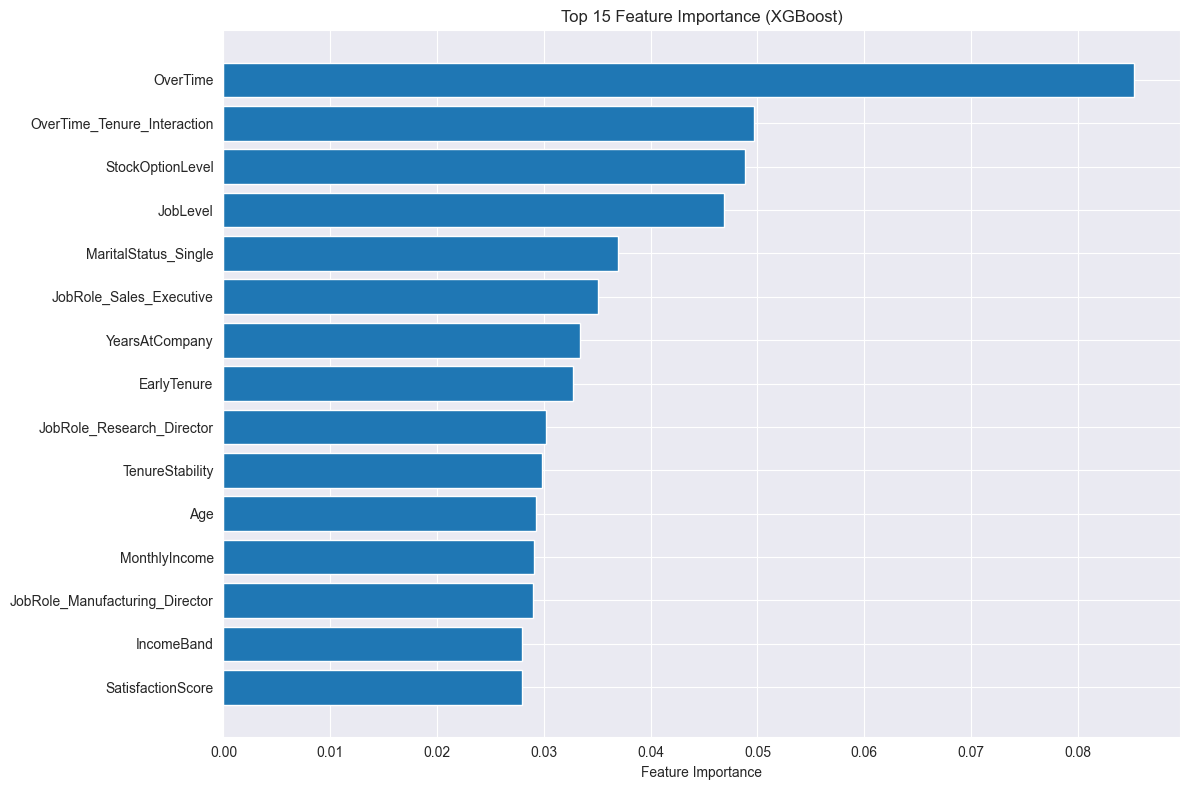

In [132]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score

best_params = study.best_params
print(best_params)

final_params = best_params.copy()
final_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",   # oder "auc"
    "random_state": 42,
    "n_jobs": -1
})

final_model = XGBClassifier(**final_params)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("Test F1:", f1_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report best_params:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

print(final_model.score(X_test, y_test))

feature_importance = final_model.feature_importances_
feature_names = X_train.columns

# Sortieren
indices = np.argsort(feature_importance)[::-1]

print("XGBoost Feature Importance:")
for i in range(min(15, len(feature_names))):
    print(f"{i+1:2d}. {feature_names[indices[i]]:30s} {feature_importance[indices[i]]:.4f}")

# Visualisieren
plt.figure(figsize=(12, 8))
plt.barh(range(15), feature_importance[indices[:15]])
plt.yticks(range(15), [feature_names[i] for i in indices[:15]])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
print('')


**SHAP ANALYSIS**

In [129]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np

X = X_train.append(X_test) if False else X
y = y_train.append(y_test) if False else y

best_params = study.best_params
final_params = best_params.copy()
final_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "random_state": 42,
    "n_jobs": -1
})

# Stratified K-Fold, damit Klassenverhältnis in allen Folds gleich bleibt
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
auc_scores = []

fold = 1
for train_idx, val_idx in skf.split(X, y):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBClassifier(**final_params)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    f1_scores.append(f1)
    auc_scores.append(auc)

    print(f"Fold {fold}")
    print("F1:", f1)
    print("AUC:", auc)
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

    fold += 1

print("Cross-Validation result")
print("F1  mean ± std:", np.mean(f1_scores), "±", np.std(f1_scores))
print("AUC mean ± std:", np.mean(auc_scores), "±", np.std(auc_scores))


Fold 1
F1: 0.48780487804878053
AUC: 0.7943766937669376
              precision    recall  f1-score   support

           0       0.92      0.82      0.86       246
           1       0.40      0.62      0.49        48

    accuracy                           0.79       294
   macro avg       0.66      0.72      0.68       294
weighted avg       0.83      0.79      0.80       294

Confusion Matrix:
 [[201  45]
 [ 18  30]]
Fold 2
F1: 0.4666666666666666
AUC: 0.7872628726287264
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       246
           1       0.39      0.58      0.47        48

    accuracy                           0.78       294
   macro avg       0.65      0.70      0.66       294
weighted avg       0.82      0.78      0.80       294

Confusion Matrix:
 [[202  44]
 [ 20  28]]
Fold 3
F1: 0.5862068965517242
AUC: 0.8656215005599104
              precision    recall  f1-score   support

           0       0.94      0.86      0.90 

Final evaluation of the model
The Optuna-tuned XGBoost model (best_params) proves to be clearly more suitable for predicting employee turnover than the baseline model. Although the overall accuracy decreases slightly, the optimized model achieves a significantly higher recall for the positive class (“Attrition = Yes”) and thus identifies almost twice as many employees who are actually at risk.
This improvement is crucial, as attrition is a highly imbalanced classification problem in which the majority of employees remain with the company. In such scenarios, accuracy is not very meaningful, as a model can systematically miss the rare but business-critical target class despite high accuracy.
The higher recall and improved F1 score of the Optuna model, on the other hand, show that it is much better at identifying attrition risks and thus delivers real added value for an HR early warning system. The slightly lower precision is an acceptable compromise, as the goal is not to minimize false alarms, but to identify employees who are potentially willing to leave at an early stage.